# <B> DELIVERABLES

## load the data and setting the libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")  # clean default style
df = pd.read_csv("data.csv")   #loading the dataset
df.head()
df = df.copy()




## 1) How many observations and features/columns do you have?

In [3]:
# Number of rows (observations) and columns (features)
n_rows, n_cols = df.shape
print(f"Observations: {n_rows}, Features: {n_cols}")

# Quick structural overview
df.info()


Observations: 15232, Features: 17
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15232 entries, 0 to 15231
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   build_year          6226 non-null   object 
 1   facades             10088 non-null  float64
 2   garden              15232 non-null  object 
 3   living_area         13504 non-null  object 
 4   locality_name       15012 non-null  object 
 5   number_rooms        13980 non-null  object 
 6   postal_code         15008 non-null  float64
 7   price               14389 non-null  float64
 8   property_id         15232 non-null  object 
 9   property_type       14236 non-null  object 
 10  property_url        15232 non-null  object 
 11  state               11116 non-null  object 
 12  swimming_pool       15232 non-null  object 
 13  terrace             13832 non-null  object 
 14  province            15008 non-null  object 
 15  property_type_name 

# 2) What is the proportion of missing values per column?

                    missing_pct
build_year            59.125525
facades               33.771008
state_mapped          27.048319
state                 27.022059
living_area           11.344538
terrace                9.191176
number_rooms           8.219538
property_type_name     6.565126
property_type          6.538866
price                  5.534401
province               1.470588
postal_code            1.470588
locality_name          1.444328
property_id            0.000000
garden                 0.000000
swimming_pool          0.000000
property_url           0.000000


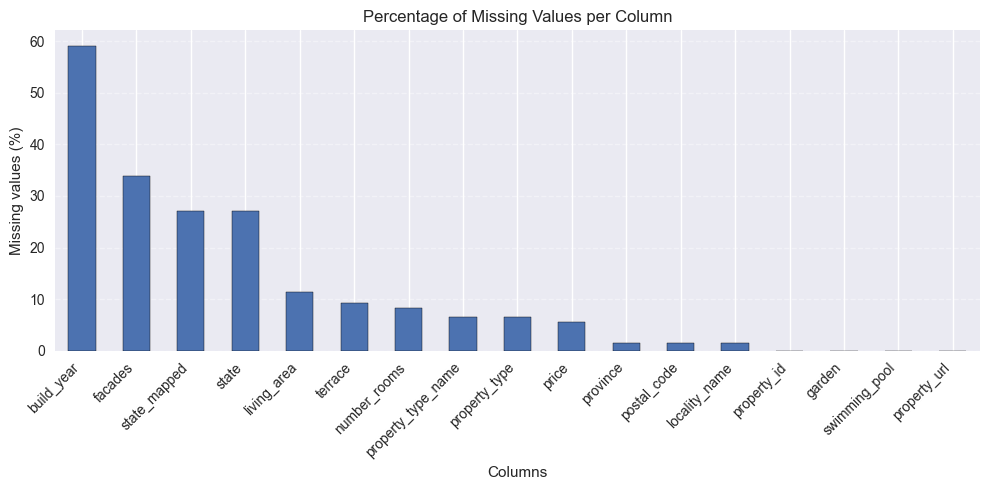

In [4]:
# Visualization missing values

# Compute missing percentage per column
missing_pct = df.isna().mean() * 100

missing_summary = (
    missing_pct
    .rename("missing_pct")          # column name will be 'missing_pct'
    .to_frame()
    .sort_values("missing_pct", ascending=False)
)

print(missing_summary)

# Plot
ax = missing_summary["missing_pct"].plot(
    kind="bar",
    figsize=(10,5),
    edgecolor="black"
)

plt.title("Percentage of Missing Values per Column")
plt.xlabel("Columns")
plt.ylabel("Missing values (%)")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()




## missing heatmap

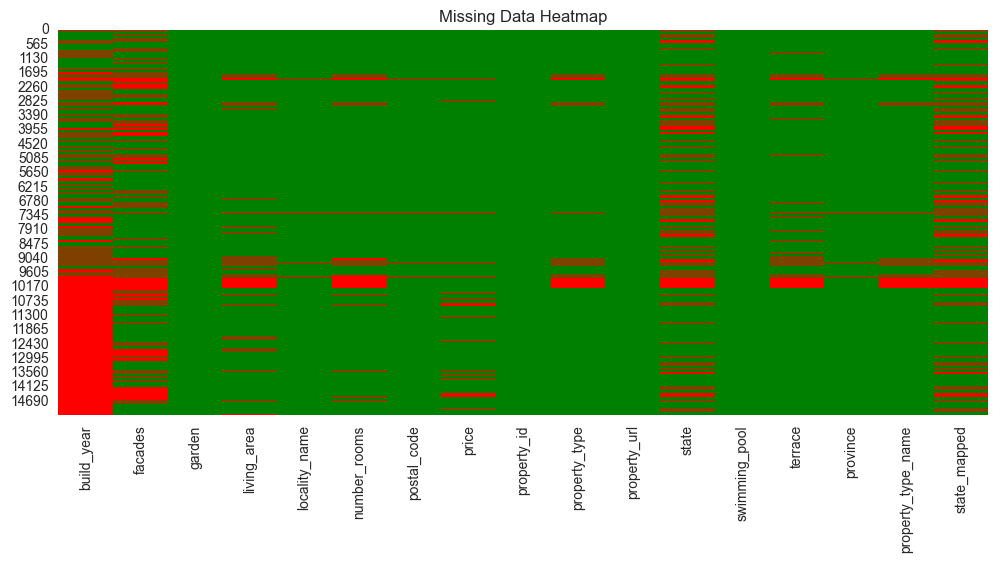

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

sns.heatmap(
    df.isna(),
    cbar=False,
    cmap=["green", "red"]   # False → green, True → red
)

plt.title("Missing Data Heatmap")
plt.show()


<b> Remarks: While certain variables, like build_year, facades, and state, have significant missingness, others, like pricing and property_id  have relatively little incomplete data.

#  ----------------data cleaning -------------

In [6]:

# Start from your original df
df_clean = df.copy()

# 1) Remove exact duplicate rows
df_clean = df_clean.drop_duplicates()

# 2) Strip leading/trailing spaces in all text columns
obj_cols = df_clean.select_dtypes(include="object").columns

for col in obj_cols:
    df_clean[col] = (
        df_clean[col]
        .astype(str)
        .str.strip()                    # " I love python " -> "I love python"
        .replace({"": np.nan,           # empty string -> NaN
                  "nan": np.nan,
                  "None": np.nan})
    )

# 3) Force numeric columns to be real numbers, set wrong encodings to NaN
numeric_like = [
    "build_year", "facades", "garden", "living_area",
    "number_rooms", "price",
    "swimming_pool", "terrace"
]

for col in numeric_like:
    if col in df_clean.columns:
        df_clean[col] = pd.to_numeric(df_clean[col], errors="coerce")
        # Any text like "abc" in these columns becomes NaN

# 4) Derive useful features
df_clean["price_per_m2"] = df_clean["price"] / df_clean["living_area"]


df_clean["postal_code"] = df_clean["postal_code"].astype("string")


# Map provinces to regions (Belgium / Wallonia / Flanders / Brussels)

def map_region(province):
    if pd.isna(province):
        return np.nan
    if province in ["Antwerp", "Limburg", "East Flanders", "West Flanders", "Flemish Brabant"]:
        return "Flanders"
    if province in ["Walloon Brabant", "Hainaut", "Liège", "Namur", "Luxembourg"]:
        return "Wallonia"
    if province == "Brussels Capital Region":
        return "Brussels"
    return np.nan

# Convert blank strings to NaN
df_clean["province"] = df_clean["province"].replace("", pd.NA)

# Remove rows with no province
df_clean = df_clean[df_clean["province"].notna()].copy()

# Map province → region
df_clean["region"] = df_clean["province"].apply(map_region)


cols_to_drop = ["property_id"]
df_model = df_clean.drop(columns=cols_to_drop)


# removing outliers of price and living area

# STEP 1 — Ensure numeric columns
df_clean["price"] = pd.to_numeric(df_clean["price"], errors="coerce")
df_clean["living_area"] = pd.to_numeric(df_clean["living_area"], errors="coerce")

# STEP 2 — IQR Outlier Removal Function
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[column] >= lower) & (df[column] <= upper)]

# STEP 3 — Remove outliers for both PRICE and LIVING AREA
df_no_outliers = df_clean.copy()
df_no_outliers = remove_outliers_iqr(df_no_outliers, "price")
df_no_outliers = remove_outliers_iqr(df_no_outliers, "living_area")

#reemove the bottom boundary price which are not real
# Remove properties below 20,000 €
df_clean = df_clean[df_clean["price"] >= 20000].copy()


# Result shape check
df_no_outliers.shape






(11514, 19)

# 3) Which variables would you delete and why?

#### URL , property_id(postal_code???) because they are identifiers,not explanatory variables. they are unique and useful for tracking but not for the price.  inaddition we want to remove furnished, equipped_kitchen and garden_area due to their relevance and mostly missing data

In [13]:
# Columns where almost all values are unique 
high_card = df.nunique().sort_values(ascending=False)
high_card

# Columns with (almost) constant values
low_var = df.nunique().sort_values()
low_var

state_mapped              2
garden                    3
property_type_name        3
swimming_pool             3
terrace                   3
facades                   4
state                    10
province                 11
property_type            23
number_rooms             28
build_year              182
living_area             795
postal_code             853
locality_name          1372
price                  2336
property_url          15229
property_id           15229
dtype: int64

 # 4) What variables are most subject to outliers?

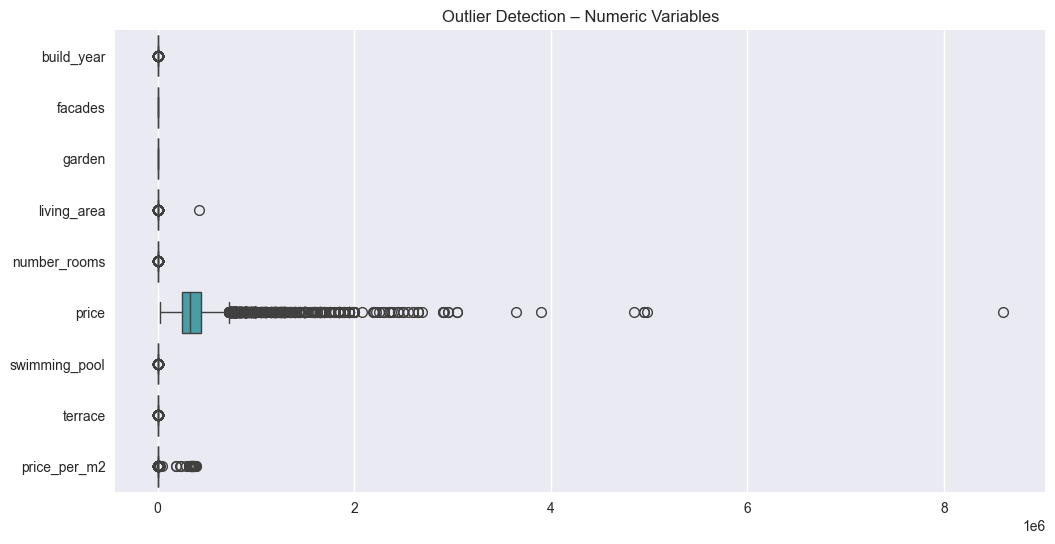

In [14]:
# numeric summary
numeric = df_clean.select_dtypes(include="number").columns

plt.figure(figsize=(12,6))
sns.boxplot(data=df_clean[numeric], orient="h")
plt.title("Outlier Detection – Numeric Variables")
plt.show()





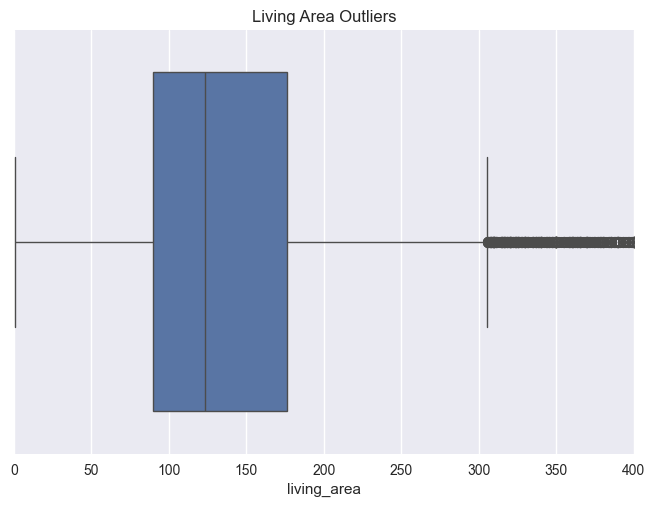

In [20]:
# boxplots
sns.boxplot(x=df_clean["living_area"])
plt.xlim(0, 400)  # hide insane outliers for clarity
plt.title("Living Area Outliers")
plt.show()






<b>          Which variables have few or no outliers?

- Facades (0–4 typical range)

- Terrace, garden, swimming_pool, furnished, equipped_kitchen (binary variables)

- These do not produce outliers because their range is fixed.

#  What is the correlation between variables and price?

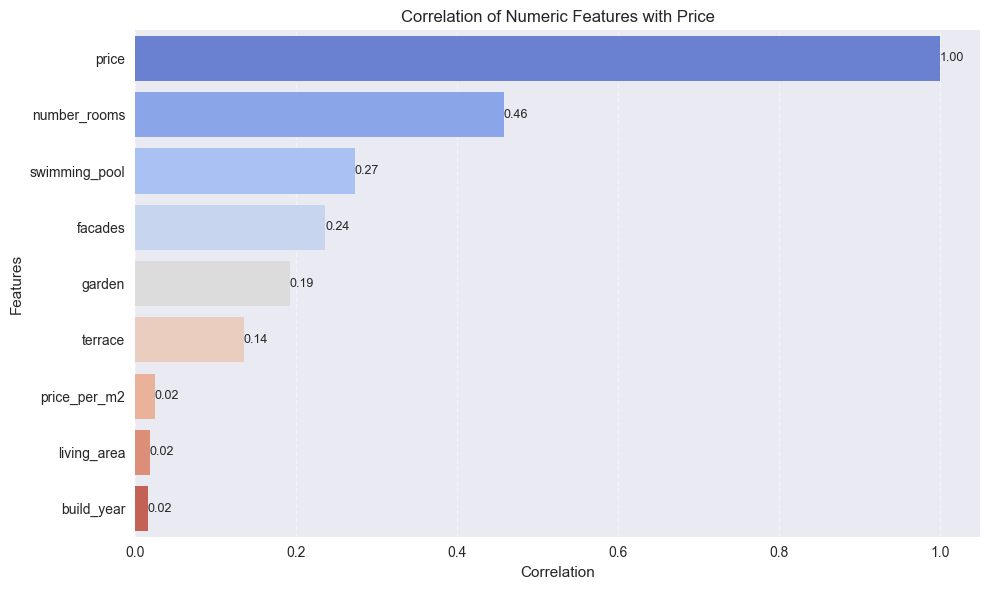

In [8]:
# Select numeric columns
numeric_cols = df_clean.select_dtypes(include=["number"]).columns.tolist()

# Ensure price_per_m2 is included
if "price_per_m2" not in numeric_cols:
    numeric_cols.append("price_per_m2")

# Compute correlations with price
corr_with_price = (
    df_clean[numeric_cols]
    .corr()["price"]
    .sort_values(ascending=False)
)

# Plot
plt.figure(figsize=(10,6))
ax = sns.barplot(
    x=corr_with_price.values,
    y=corr_with_price.index,
    hue=corr_with_price.index,   # fix
    palette="coolwarm",
    dodge=False,
    legend=False
)

plt.title("Correlation of Numeric Features with Price")
plt.xlabel("Correlation")
plt.ylabel("Features")
plt.grid(axis="x", linestyle="--", alpha=0.4)

# Add correlation labels
for i, value in enumerate(corr_with_price.values):
    ax.text(
        value,
        i,
        f"{value:.2f}",
        va="center",
        ha="left" if value > 0 else "right",
        fontsize=9
    )

plt.tight_layout()
plt.show()




<b> Larger properties are typically more expensive, as seen by the significant correlation between price and living area and number of rooms. Geographical factors like postal code and location can have a big impact on prices. Because they are less common and frequently found in particular house types and upscale properties, things like gardens, terraces, and pools have a favorable but more limited impact. 


<b> We find that the number of rooms and living area have a high correlation, establishing a size-related group of variables that together represent the property's physical volume. Price per square meter and location factors also frequently correlate, particularly within a given region. Another minor correlation group that is typical of higher-end residences is formed by the likelihood of amenities like a garden, terrace, and swimming pool to co-occur.

### catagorical variables

## Least/most expensive municipalities by median

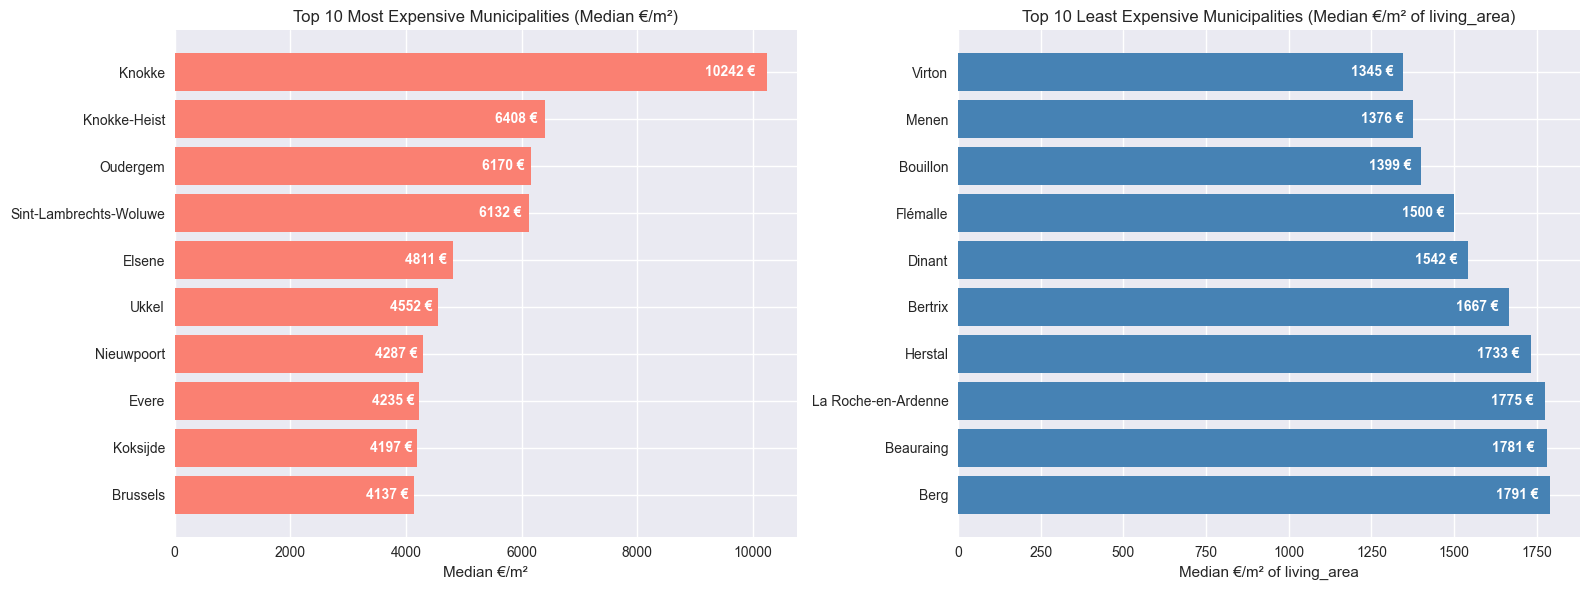

In [9]:

# Compute municipality-level stats
municipality_stats = (
    df_clean.groupby("locality_name")
    .agg(
        n=("price", "count"),
        median_price_m2=("price_per_m2", "median")
    )
    .query("n >= 20")        # keep only municipalities with sufficient data
    .dropna(subset=["median_price_m2"])
)

# Top 10 most expensive
top10 = municipality_stats.sort_values("median_price_m2", ascending=False).head(10)

# Bottom 10 least expensive
bottom10 = municipality_stats.sort_values("median_price_m2", ascending=True).head(10)

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# -------------------------
# LEFT: TOP 10 MOST EXPENSIVE
# -------------------------
ax = axes[0]
values = top10["median_price_m2"]
labels = top10.index

bars = ax.barh(labels, values, color="salmon")
ax.set_title("Top 10 Most Expensive Municipalities (Median €/m²)")
ax.set_xlabel("Median €/m²")
ax.invert_yaxis()

# Add value labels inside bars
for bar, val in zip(bars, values):
    width = bar.get_width()
    ax.text(
        width * 0.98,
        bar.get_y() + bar.get_height() / 2,
        f"{val:.0f} €",
        ha="right", va="center", color="white", fontsize=10, fontweight="bold"
    )

# -------------------------
# RIGHT: BOTTOM 10 LEAST EXPENSIVE
# -------------------------
ax = axes[1]
values = bottom10["median_price_m2"]
labels = bottom10.index

bars = ax.barh(labels, values, color="steelblue")
ax.set_title("Top 10 Least Expensive Municipalities (Median €/m² of living_area)")
ax.set_xlabel("Median €/m² of living_area")
ax.invert_yaxis()

# Add value labels inside bars
for bar, val in zip(bars, values):
    width = bar.get_width()
    ax.text(
        width * 0.98,
        bar.get_y() + bar.get_height() / 2,
        f"{val:.0f} €",
        ha="right", va="center", color="white", fontsize=10, fontweight="bold"
    )

plt.tight_layout()
plt.show()


## Average Property Price by Region

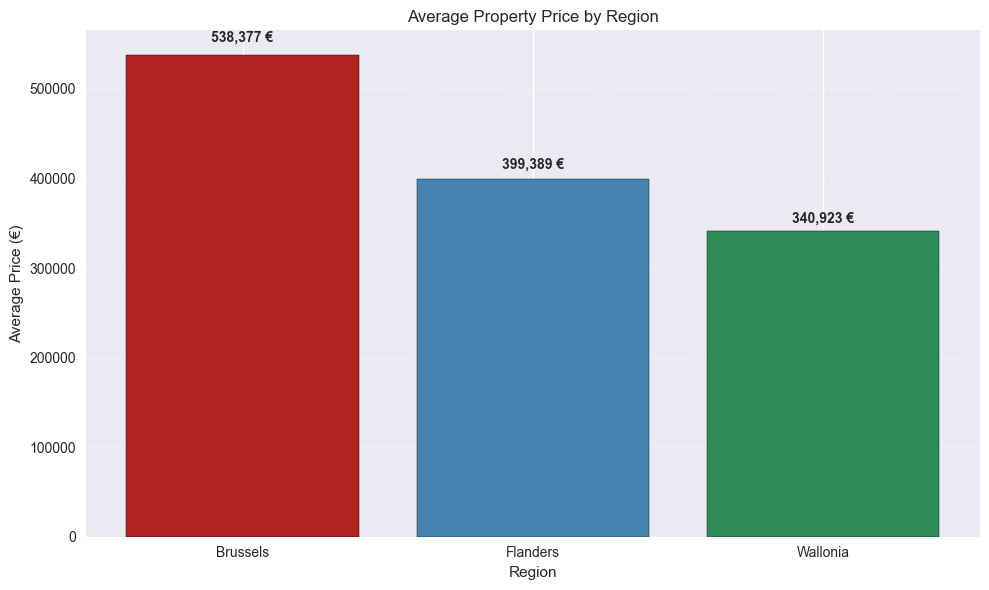

In [10]:


# Custom color map for the 3 regions
import pandas as pd
import matplotlib.pyplot as plt

# Custom color map
region_colors = {
    "Flanders": "steelblue",
    "Wallonia": "seagreen",
    "Brussels": "firebrick"
}

# Compute average price per region
avg_price_region = (
    df_clean.groupby("region")["price"]
    .mean()
    .dropna()
    .sort_values(ascending=False)
)

# Extract colors in the order of the index
colors = [region_colors[r] for r in avg_price_region.index]

plt.figure(figsize=(10, 6))
ax = plt.bar(avg_price_region.index, avg_price_region.values, color=colors, edgecolor="black")

plt.title("Average Property Price by Region")
plt.xlabel("Region")
plt.ylabel("Average Price (€)")
plt.grid(axis="y", linestyle="--", alpha=0.4)

# Add value labels
for i, value in enumerate(avg_price_region.values):
    plt.text(
        i,
        value * 1.02,
        f"{value:,.0f} €",
        ha="center",
        va="bottom",
        fontsize=10,
        fontweight="bold"
    )

plt.tight_layout()
plt.show()


## Price vs living area


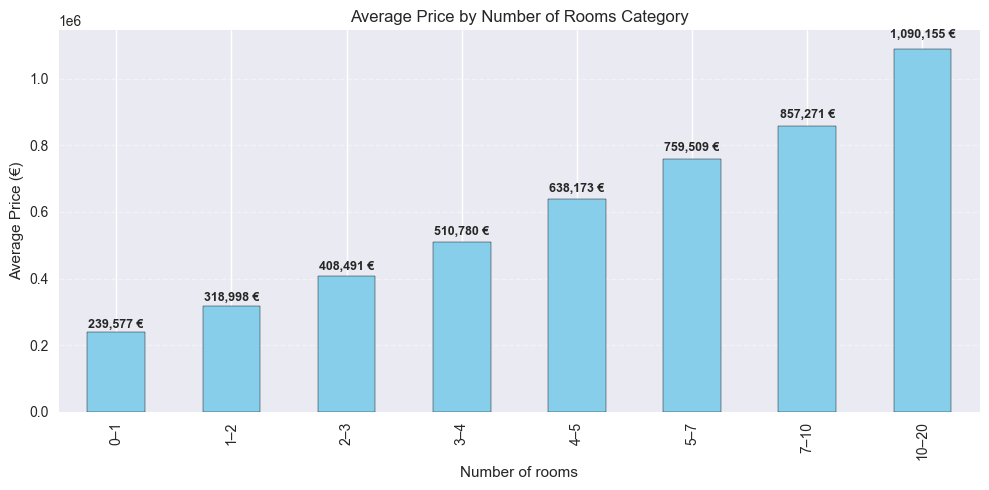

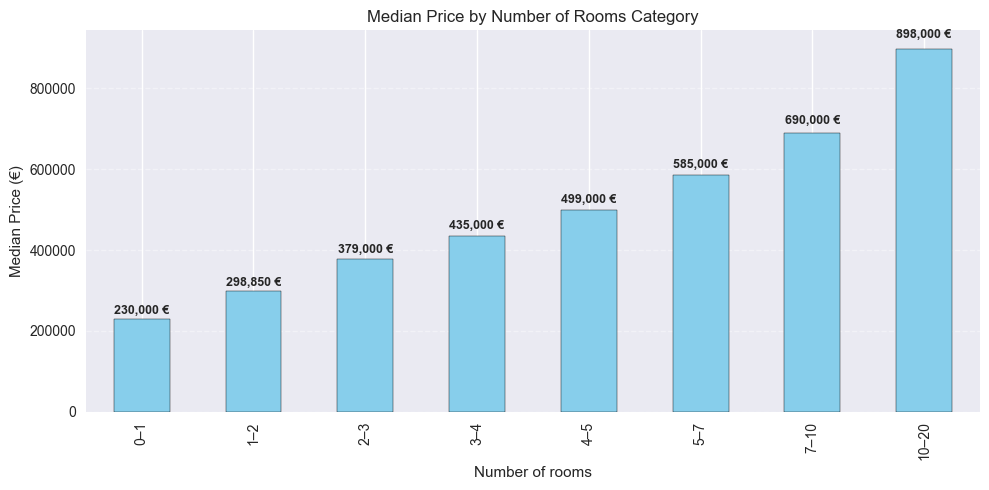

In [12]:


# Ensure required columns exist
if "number_rooms" in df_clean.columns and "price" in df_clean.columns:

    # Convert to numeric safely
    df_clean["number_rooms"] = pd.to_numeric(df_clean["number_rooms"], errors="coerce")
    df_clean["price"] = pd.to_numeric(df_clean["price"], errors="coerce")

    # Define bins for number of rooms
    bins = [0, 1, 2, 3, 4, 5, 7, 10, 20]
    labels = ["0–1", "1–2", "2–3", "3–4", "4–5", "5–7", "7–10", "10–20"]

    # Create binned room categories
    df_clean["room_bin"] = pd.cut(df_clean["number_rooms"], bins=bins, labels=labels)

    # Compute average price per room bin
    price_per_room_bin = (
        df_clean.groupby("room_bin", observed=False)["price"]
        .mean()
        .reindex(labels)
        .dropna()
    )

    # ------------------------------
    # PLOT: Average Price by Number of Rooms Category
    # ------------------------------
    plt.figure(figsize=(10,5))
    ax = price_per_room_bin.plot(kind="bar", color="skyblue", edgecolor="black")

    plt.title("Average Price by Number of Rooms Category")
    plt.xlabel("Number of rooms")
    plt.ylabel("Average Price (€)")
    plt.grid(axis="y", linestyle="--", alpha=0.4)

    # Add labels on bars
    for i, value in enumerate(price_per_room_bin.values):
        ax.text(
            i,
            value * 1.02,
            f"{value:,.0f} €",
            ha="center",
            va="bottom",
            fontsize=9,
            fontweight="bold"
        )

    plt.tight_layout()
    plt.show()

    median_price_per_room_bin = (
    df_clean.groupby("room_bin", observed=False)["price"]
    .median()
    .reindex(labels)
    .dropna()
)

plt.figure(figsize=(10,5))

ax = median_price_per_room_bin.plot(
    kind="bar",
    color="skyblue",
    edgecolor="black"
)

plt.title("Median Price by Number of Rooms Category")
plt.xlabel("Number of rooms")
plt.ylabel("Median Price (€)")
plt.grid(axis="y", linestyle="--", alpha=0.4)

# Add labels on bars
for i, value in enumerate(median_price_per_room_bin.values):
    ax.text(
        i,
        value * 1.02,
        f"{value:,.0f} €",
        ha="center",
        va="bottom",
        fontsize=9,
        fontweight="bold"
    )

plt.tight_layout()
plt.show()


## properties according to their price bins

price_range
20k-30k         7
30k-50k        25
50k–100k      200
100k–200k    1651
200k–300k    4176
300k-400k    3818
400k-500k    2119
500k–1M      2022
>1M           355
Name: count, dtype: int64


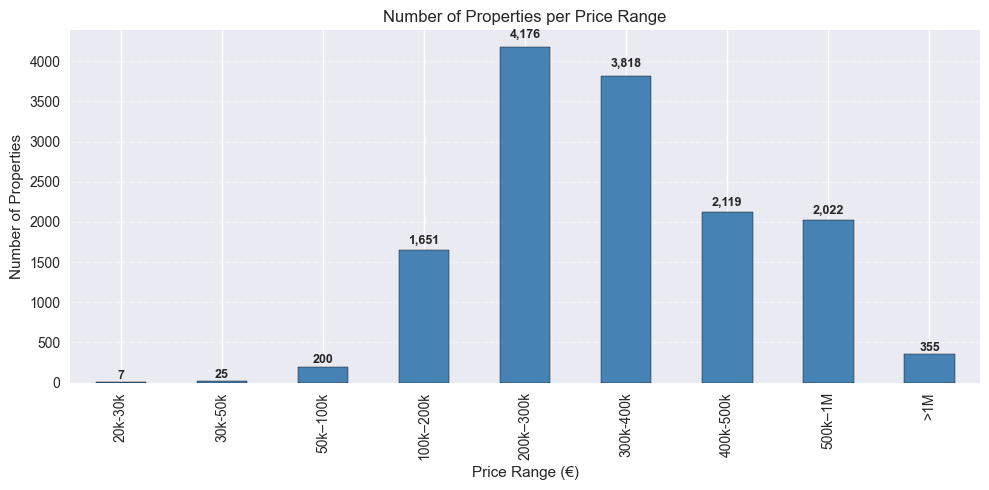

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure price is numeric
df_clean["price"] = pd.to_numeric(df_clean["price"], errors="coerce")

# Define your price bins
bins = [20000,30000,50000, 100000, 200000,300000,400000, 500000, 1000000, float("inf")]
labels = [
    
    "20k-30k",
    "30k-50k",
    "50k–100k",
    "100k–200k",
    "200k–300k",
    "300k-400k",
    "400k-500k",
    "500k–1M",
    ">1M"
]

# Categorize prices into these bins
df_clean["price_range"] = pd.cut(df_clean["price"], bins=bins, labels=labels)

# Count how many properties fall in each price range
price_counts = df_clean["price_range"].value_counts().sort_index()

print(price_counts)

plt.figure(figsize=(10,5))
ax = price_counts.plot(kind="bar", color="steelblue", edgecolor="black")

plt.title("Number of Properties per Price Range")
plt.xlabel("Price Range (€)")
plt.ylabel("Number of Properties")
plt.grid(axis="y", linestyle="--", alpha=0.4)

# Add numbers on top of each bar
for i, value in enumerate(price_counts.values):
    plt.text(
        i, value * 1.02,
        f"{value:,}", 
        ha="center", va="bottom", fontsize=9, fontweight="bold"
    )

plt.tight_layout()
plt.show()



## Price vs type of properties

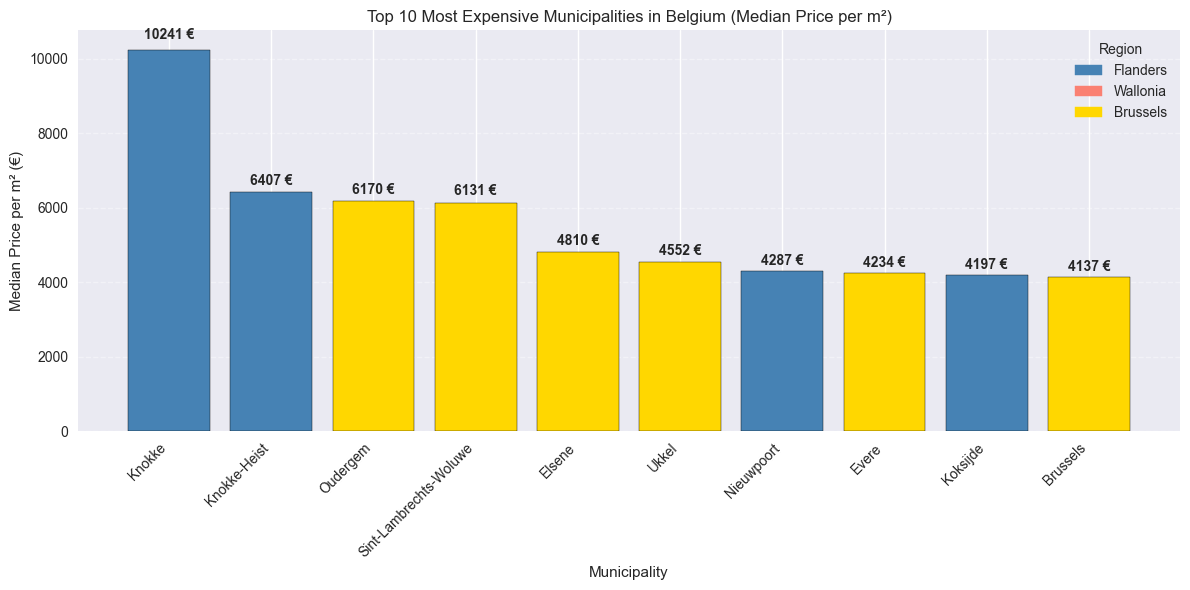

In [20]:


# Compute per-municipality median price per m²
municipality_ppm2 = (
    df_clean.groupby(["locality_name", "region"])["price_per_m2"]
    .median()
    .dropna()
    .reset_index()
)

# Keep only municipalities with >= 20 listings (more reliable)
counts = df_clean.groupby("locality_name")["price"].count()
valid_munis = counts[counts >= 20].index
municipality_ppm2 = municipality_ppm2[municipality_ppm2["locality_name"].isin(valid_munis)]

# Top 10 most expensive municipalities
top10 = municipality_ppm2.sort_values("price_per_m2", ascending=False).head(10)

# Region colors
palette = {
    "Flanders": "steelblue",
    "Wallonia": "salmon",
    "Brussels": "gold"
}
colors = top10["region"].map(palette)

# Plot
plt.figure(figsize=(12,6))
bars = plt.bar(top10["locality_name"], top10["price_per_m2"], color=colors, edgecolor="black")

plt.title("Top 10 Most Expensive Municipalities in Belgium (Median Price per m²)")
plt.xlabel("Municipality")
plt.ylabel("Median Price per m² (€)")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.4)

# Add labels on each bar
for bar, value in zip(bars, top10["price_per_m2"]):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        value * 1.02,
        f"{int(value)} €",
        ha="center",
        va="bottom",
        fontsize=10,
        fontweight="bold"
    )

# Legend
handles = [plt.Rectangle((0,0),1,1, color=palette[r]) for r in palette]
plt.legend(handles, palette.keys(), title="Region")

plt.tight_layout()
plt.show()



# Mapping provinces → region colors
region_color_map = {
    "Flanders": "gold",
    "Wallonia": "steelblue",
    "Brussels": "purple"
}

# Ensure region column exists
def map_region(province):
    if province in ["Antwerp", "Limburg", "East Flanders", "West Flanders", "Flemish Brabant"]:
        return "Flanders"
    if province in ["Walloon Brabant", "Hainaut", "Liège", "Namur", "Luxembourg"]:
        return "Wallonia"
    if province == "Brussels Capital Region":
        return "Brussels"
    return None

df_clean["region"] = df_clean["province"].apply(map_region)

# Compute median price per m² per province
province_ppm2 = (
    df_clean.groupby("province")["price_per_m2"]
    .median()
    .dropna()
    .sort_values()
)

# Pick bottom 5 and top 5
bottom5 = province_ppm2.head(5)
top5 = province_ppm2.tail(5)

# Combine them
combined = pd.concat([bottom5, top5])

# Assign colors based on region
bar_colors = [
    region_color_map[df_clean[df_clean["province"] == prov]["region"].iloc[0]]
    for prov in combined.index
]



## Province-level price stats

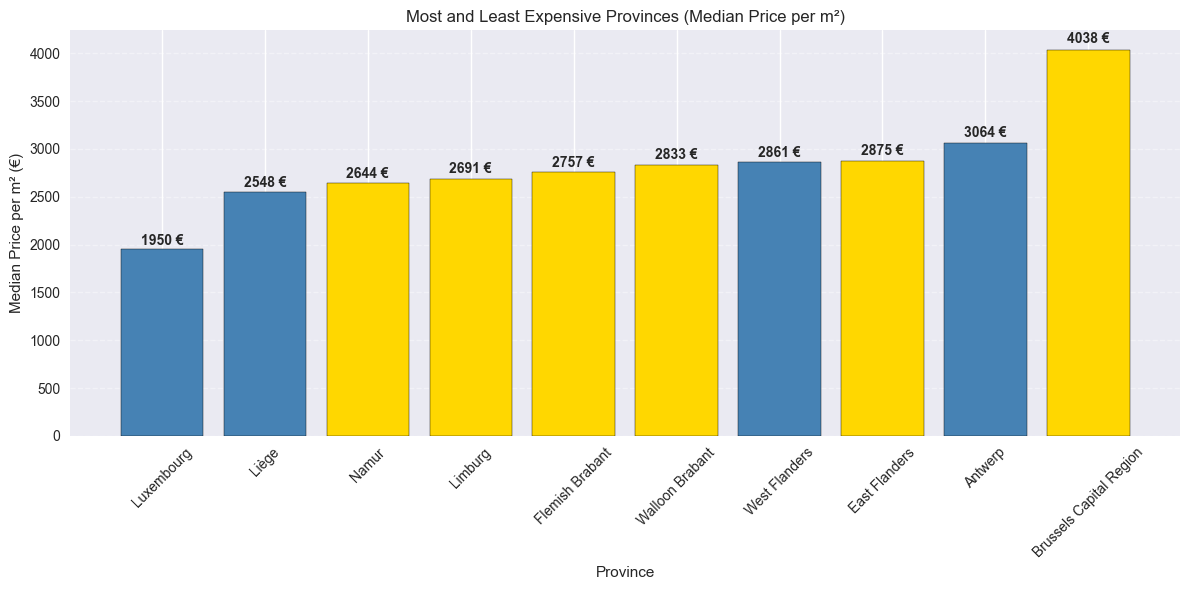

In [19]:


# Compute median price per m² per province
province_ppm2 = (
    df_clean.groupby("province")["price_per_m2"]
    .median()
    .dropna()
    .sort_values()
)

# Bottom 5 (cheapest)
bottom5 = province_ppm2.head(5)

# Top 5 (most expensive)
top5 = province_ppm2.tail(5)

# Combine them into one DataFrame for plotting
combined = pd.concat([bottom5, top5])





# Compute median price per m² per province
# Compute median price per m² per province
province_ppm2 = (
    df_clean.groupby("province")["price_per_m2"]
    .median()
    .dropna()
    .sort_values()
)


# -------------------------
# VERTICAL BAR PLOT
# -------------------------
plt.figure(figsize=(12, 6))
bars = plt.bar(combined.index, combined.values, color=colors, edgecolor="black")

plt.title("Most and Least Expensive Provinces (Median Price per m²)")
plt.ylabel("Median Price per m² (€)")
plt.xlabel("Province")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.4)

# Add labels on top of each bar
for bar, value in zip(bars, combined.values):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        value * 1.01,
        f"{value:.0f} €",
        ha="center",
        va="bottom",
        fontsize=10,
        fontweight="bold"
    )

plt.tight_layout()
plt.show()


## Price by state of property

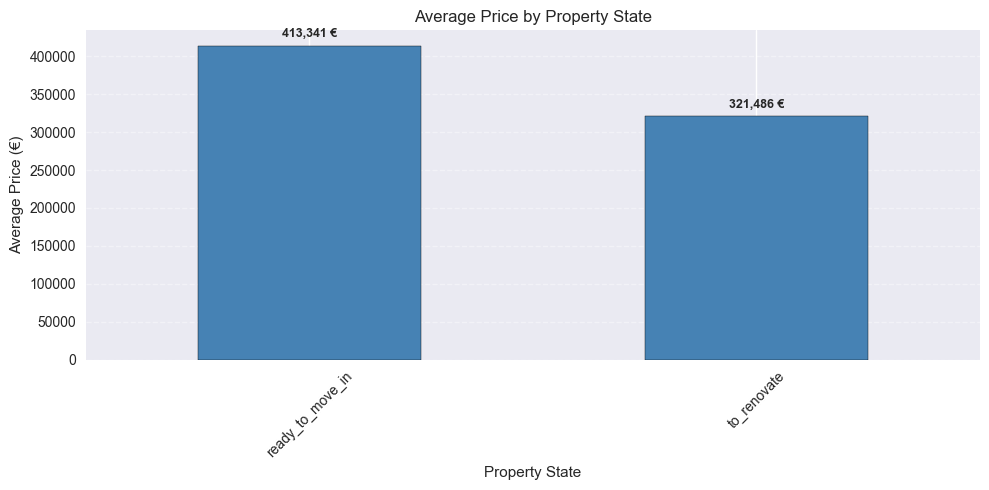

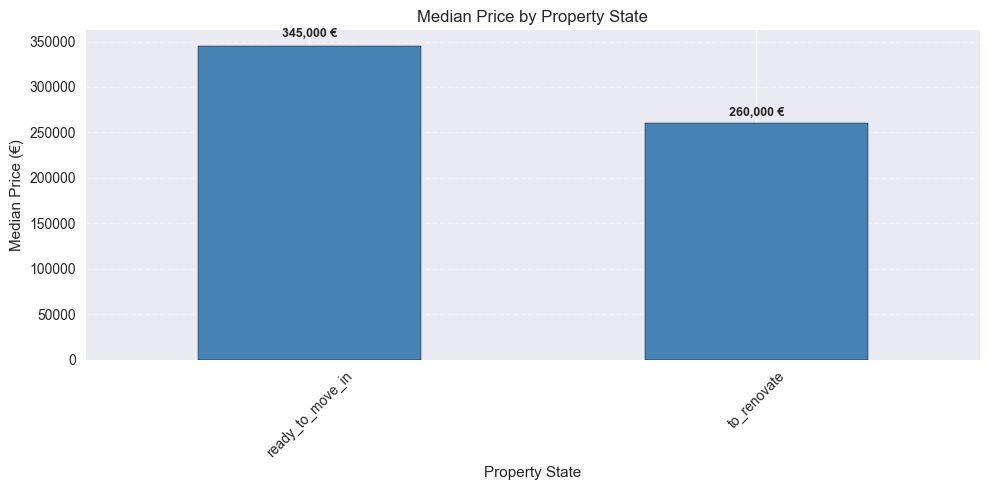

In [21]:


# Compute average price per state
avg_price_state = (
    df_clean.groupby("state_mapped", observed=False)["price"]
    .mean()
    .dropna()
    .sort_values(ascending=False)
)

plt.figure(figsize=(10,5))
ax = avg_price_state.plot(kind="bar", color="steelblue", edgecolor="black")

plt.title("Average Price by Property State")
plt.xlabel("Property State")
plt.ylabel("Average Price (€)")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.4)

# Add value labels
for i, value in enumerate(avg_price_state.values):
    ax.text(
        i,
        value * 1.02,
        f"{value:,.0f} €",
        ha="center",
        va="bottom",
        fontsize=9,
        fontweight="bold"
    )

plt.tight_layout()
plt.show()

# Compute median price per state
median_price_state = (
    df_clean.groupby("state_mapped", observed=False)["price"]
    .median()
    .dropna()
    .sort_values(ascending=False)
)

plt.figure(figsize=(10,5))
ax = median_price_state.plot(kind="bar", color="steelblue", edgecolor="black")

plt.title("Median Price by Property State")
plt.xlabel("Property State")
plt.ylabel("Median Price (€)")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.4)

# Add value labels
for i, value in enumerate(median_price_state.values):
    ax.text(
        i,
        value * 1.02,
        f"{value:,.0f} €",
        ha="center",
        va="bottom",
        fontsize=9,
        fontweight="bold"
    )

plt.tight_layout()
plt.show()


## Number of facades vs price

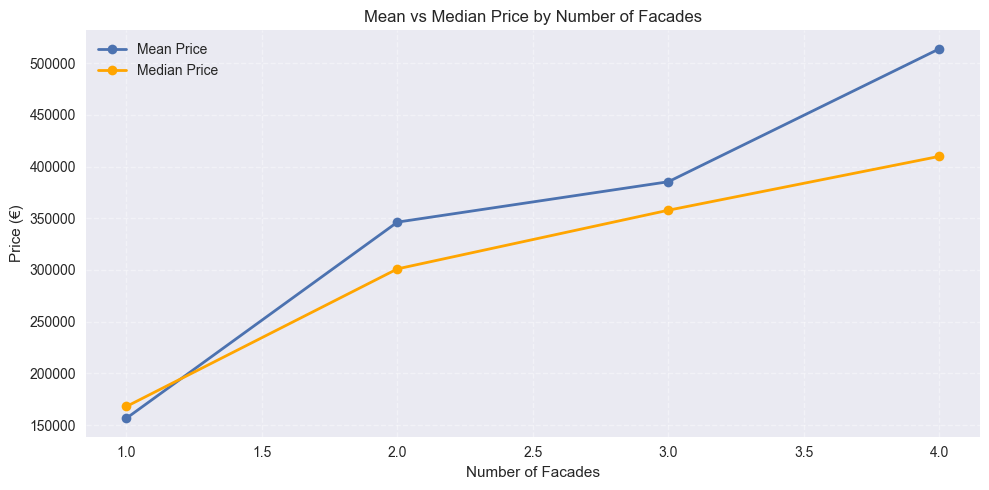

In [33]:
# Ensure numeric types
df_clean["facades"] = pd.to_numeric(df_clean["facades"], errors="coerce")
df_clean["price"] = pd.to_numeric(df_clean["price"], errors="coerce")

# Remove rows with missing facades or price
df_fac = df_clean.dropna(subset=["facades", "price"])

# Compute mean & median price for each number of facades
facade_stats = (
    df_fac.groupby("facades")["price"]
    .agg(["mean", "median"])
    .sort_index()
)

plt.figure(figsize=(10,5))

# Plot mean
plt.plot(
    facade_stats.index,
    facade_stats["mean"],
    marker="o",
    linewidth=2,
    label="Mean Price",
)

# Plot median
plt.plot(
    facade_stats.index,
    facade_stats["median"],
    marker="o",
    linewidth=2,
    label="Median Price",
    color="orange"   # <-- requested color
)

plt.title("Mean vs Median Price by Number of Facades")
plt.xlabel("Number of Facades")
plt.ylabel("Price (€)")
plt.grid(linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

## Median Price by Living Area Category

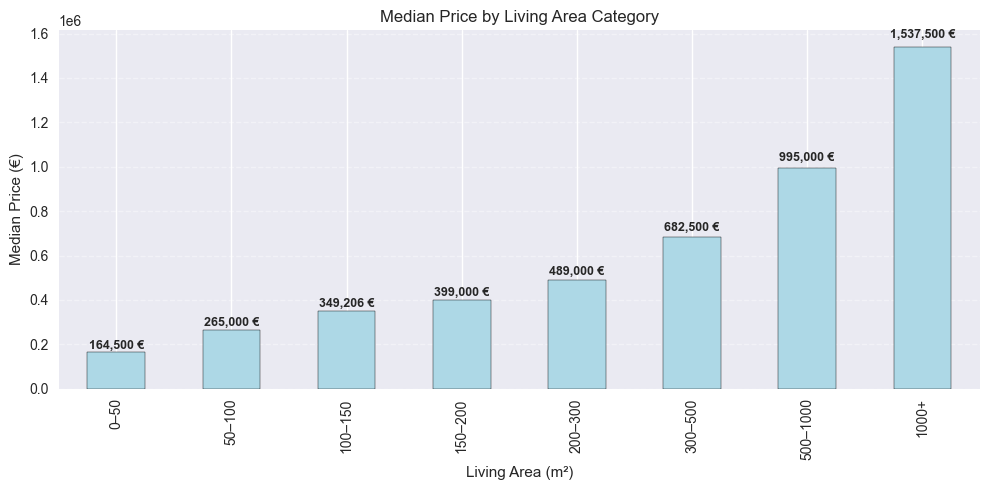

In [29]:
# Convert to numeric
df_clean["living_area"] = pd.to_numeric(df_clean["living_area"], errors="coerce")
df_clean["price"] = pd.to_numeric(df_clean["price"], errors="coerce")

# Define bins
bins = [0, 50, 100, 150, 200, 300, 500, 1000, float("inf")]
labels = ["0–50", "50–100", "100–150", "150–200",
          "200–300", "300–500", "500–1000", "1000+"]

# Assign bin without warnings
df_clean.loc[:, "living_area_bin"] = pd.cut(
    df_clean["living_area"], bins=bins, labels=labels
)

# Compute median price per bin
median_price_per_area_bin = (
    df_clean.groupby("living_area_bin", observed=False)["price"]
    .median()
    .reindex(labels)
    # OPTIONAL: remove if you want bins to show even when median = NaN
    .dropna()
)

# Plot
plt.figure(figsize=(10,5))
ax = median_price_per_area_bin.plot(
    kind="bar",
    edgecolor="black",
    color="lightblue"   # <-- requested color
)

plt.title("Median Price by Living Area Category")
plt.xlabel("Living Area (m²)")
plt.ylabel("Median Price (€)")
plt.grid(axis="y", linestyle="--", alpha=0.4)

# Labels
for i, value in enumerate(median_price_per_area_bin.values):
    ax.text(
        i,
        value * 1.02,
        f"{value:,.0f} €",
        ha="center",
        va="bottom",
        fontsize=9,
        fontweight="bold"
    )

plt.tight_layout()
plt.show()
